In [ ]:
import json 
import logging
import copy
import sys
import ast
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import ast 

# Dynamically get the backend path relative to the notebook location
notebook_path = Path().resolve()
project_root = notebook_path.parents[1]  # Go up to project root (adjust if needed)
sys.path.insert(0, str(project_root))
local_path = project_root / 'back_end'
sys.path.insert(0, str(local_path))

from src.utils.utils import *
from src.utils.logging_utils import *
from main import *
from fast_api import plot_96wells

multimer_size = 4

# download CSV files
def download_data_dict(multimer_size):
    input_dir = project_root / 'back_end' / 'data' / 'filtered_reaction_database' / f'multimer_size_{multimer_size}'

    combined_database = pd.read_csv(input_dir / 'combined_database.csv', index_col=0)
    context_history = pd.read_csv(input_dir / 'context_history.csv', index_col=0)
    donor_history = pd.read_csv(input_dir / 'donor_history.csv', index_col=0)
    reaction_history = pd.read_csv(input_dir / 'reaction_history.csv', index_col=0)
    ubiquitin_history = pd.read_csv(input_dir / 'ubiquitin_history.csv', index_col=0)

    return {
        'combined_database': combined_database,
        'context_history': context_history,
        'donor_history': donor_history,
        'reaction_history': reaction_history,
        'ubiquitin_history': ubiquitin_history
    }

data_dict = download_data_dict(multimer_size)
combined_database = data_dict['combined_database']
context_history = data_dict['context_history']
donor_history = data_dict['donor_history']
reaction_history = data_dict['reaction_history']
ubiquitin_history = data_dict['ubiquitin_history']

In [ ]:
# ============================================
# Functions 
# ============================================

# This function creates an encoded dictionary that maps combinations of donors and enzymes to unique integers.
def create_e_d_encoded_dictionary(list_of_enzymes, list_of_donors):
    """
    Creates a dictionary that encodes the combinations of donors and enzymes.
    
    Parameters:
        list_of_enzymes (list): List of enzyme names.
        list_of_donors (list): List of donor names.
        
    Returns:
        dict: Dictionary mapping (donor, enzyme) tuples to unique integers.
    """
    e_d_encoded_dictionary = {}
    count = 1 
    for i in list_of_enzymes: 
        for j in list_of_donors:
            ## these are the self reactions should not be included
            if ((j == 'ubi_ubq_1_K48_SMAC') & (i=='Ubc13/Mms2')) | ((j == 'ubi_ubq_1_K63_SMAC') & (i=='Ube2K'))|((j == 'ubi_ubq_1_K63_SMAC') & (i=='gp78/Ube2g2')):
                count = count
            else:
                e_d_encoded_dictionary[j, i] = count 
                count = count+1 
    return e_d_encoded_dictionary  

def select_columns_by_keyword(combined_database, keyword):
    """
    Select columns from a DataFrame that contain a specific keyword (case-insensitive).

    Parameters:
        combined_database (pd.DataFrame): The input DataFrame.
        keyword (str): The keyword to search for in column names.

    Returns:
        list: A list of matching column names.
    """
    return [col for col in combined_database.columns if keyword.lower() in col.lower()]


def get_combined_data(combined_database, index_list, table_origin, keyword='formation'):
    """
    Returns formation-related columns for specified indices and table_origin,
    preserving the order of index_list.
    
    Parameters:
        combined_database (pd.DataFrame): The full database to filter from.
        index_list (list of int): List of index values to retrieve.
        table_origin (str): 'Reactions', 'Donors', etc.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only formation-related columns.
    """
    # Filter by condition
    filtered_rows = combined_database[
        (combined_database['index'].isin(index_list)) &
        (combined_database['table_origin'] == table_origin)
    ]

    # Preserve order of index_list
    filtered_rows_sorted = filtered_rows.set_index('index').loc[index_list].reset_index()

    # Select columns that contain 'formation' in the name
    formation_columns = select_columns_by_keyword(combined_database, keyword)
    
    # Extract only those columns
    return filtered_rows_sorted[formation_columns]

# Modified folding function: always creates two columns, padding with None if necessary
def fold_series(series, chunk_length=8, min_chunks=2):
    total_length = len(series)
    num_chunks = max(int(np.ceil(total_length / chunk_length)), min_chunks)
    padded = series.tolist() + [None] * (num_chunks * chunk_length - total_length)
    folded = [padded[i * chunk_length:(i + 1) * chunk_length] for i in range(num_chunks)]
    return pd.DataFrame(folded).transpose()

# Fold DataFrame function: applies folding to each column and renames columns for clarity
def fold_dataframe(df):
    """
    Apply folding to each column in a DataFrame using a provided fold_series function,
    then rename columns for clarity.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        fold_series (function): Function to apply to each column (e.g., for encoding).

    Returns:
        pd.DataFrame: The folded and renamed DataFrame.
    """
    # Check for maximum length constraint
    MAX_LENGTH = 16
    if len(df) > MAX_LENGTH:
        raise ValueError(f"DataFrame length {len(df)} exceeds maximum allowed length of {MAX_LENGTH}.")

    # Apply folding to each column
    folded_columns = [fold_series(df[col]) for col in df.columns]

    # Concatenate folded columns
    enzymes_donors_96 = pd.concat(folded_columns, axis=1, keys=df.columns)

    # Rename columns for clarity
    enzymes_donors_96.columns = [f"{col}_{i+1}" for col, i in enzymes_donors_96.columns]

    return enzymes_donors_96


def pad_and_validate_dataframe(input_df, required_columns=12):
    """
    Pad the DataFrame with empty columns if it has fewer than required_columns.
    Raise an error if it exceeds the limit. Convert NaNs to 0 and cast to integers.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame to pad and validate.
        required_columns (int): The required number of columns (default: 12).

    Returns:
        pd.DataFrame: A cleaned and padded DataFrame with exactly required_columns columns.
    """
    current_columns = input_df.shape[1]

    # If fewer than required, add empty (None) columns
    if current_columns < required_columns:
        for i in range(current_columns + 1, required_columns + 1):
            input_df[f"padding_{i}"] = None

    # If more than required, raise an error
    elif current_columns > required_columns:
        raise ValueError(f"Final DataFrame has {current_columns} columns, which exceeds the {required_columns}-column limit.")

    # Convert the DataFrame to integers, filling NaNs with 0
    input_df = input_df.fillna(0).infer_objects().astype(int)

    return input_df

def inner_create_plate_dfs(data_dict, indexed_values, multimer_size=4):
    """    
    Creates a DataFrame with formation data for dimer, trimer, and tetramer levels,
    including encoded values based on donor and reaction combinations.  
    Parameters:
        combined_database (pd.DataFrame): The full database to filter from.
        indexed_values (list of int): List of index values for tetramers.
        e_d_encoded_dictionary (dict): Dictionary mapping (donor, reaction) tuples to
    """    
    # ================================
    # Extract the necessary data from the data_dict
    # ================================
    combined_database = data_dict['combined_database']
    context_history = data_dict['context_history']

    # ================================
    # Determine the levels of formation based on multimer size
    # ================================
    if multimer_size == 4:
        levels = ['dimer', 'trimer', 'tetramer']
    elif multimer_size == 5:
        levels = ['dimer', 'trimer', 'tetramer', 'pentamer']

    # ================================
    # Reactants and Donors
    # ================================
    # Inputs:
    # combined_database: The full database to filter from.
    # indexed_values: List of index values for tetramers.
    # e_d_encoded_dictionary: Dictionary mapping (donor, reaction) tuples to unique integers.
    # ================================

    # List of donors and enzymes to encode
    list_of_donors = [
        'ubi_ubq_1_K48_SMAC', 
        'ubi_ubq_1_K63_SMAC', 
        'ubi_ubq_1_K48_SMAC_K63_ABOC', 
        'ubi_ubq_1_K48_ABOC_K63_SMAC', 
        'ubi_ubq_1_K48_ABOC_K63_ABOC'
        ]

    list_of_enzymes = [
        'gp78/Ube2g2', 
        'Ube2K', 
        'Ubc13/Mms2'
        ]
    
    # Create the encoded dictionary
    e_d_encoded_dictionary = create_e_d_encoded_dictionary(list_of_enzymes, list_of_donors)

    # ================================
     # Create an empty DataFrame to hold the results
    enzymes_donors_96 = pd.DataFrame()

    # Filter the combined database for reactions and donors based on indexed values
    filtered_reactions = get_combined_data(combined_database, indexed_values, 'Reactions', 'formation')
    filtered_donors = get_combined_data(combined_database, indexed_values, 'Donors', 'formation')

    # Iterate through each level of formation
    for level in levels:
        if level == 'dimer':
            continue  # Skip this iteration
        else:
            # Create columns for donor and reaction formation data
            enzymes_donors_96[f'{level}_donor'] = filtered_donors[f'{level}_formation']
            enzymes_donors_96[f'{level}_reaction'] = filtered_reactions[f'{level}_formation']

            # Encode the donor and reaction combinations using the encoded dictionary
            # e_d_encoded mean enzyme donor encoded
            enzymes_donors_96[f'{level}_e_d_encoded'] = enzymes_donors_96.apply(
                lambda row: e_d_encoded_dictionary.get((row[f'{level}_donor'], row[f'{level}_reaction']), None), axis=1
            )

    # Pull only the encoded columns
    e_d_encoded_columns = select_columns_by_keyword(enzymes_donors_96, '_e_d_encoded')

    # Filter the DataFrame to keep only the encoded columns
    enzymes_donors_96 = enzymes_donors_96[e_d_encoded_columns]

    # Fold the DataFrame to ensure each column has a maximum of 8 values
    # Final DataFrame should have 12 columns, padded if necessary with encoded values
    enzymes_donors_96 = fold_dataframe(enzymes_donors_96)
    
    # ================================
    # Functions for Deprotections
    # ================================
    # Inputs:
    # filtered_reactions: The filtered reactions DataFrame containing deprotection information.
    # indexed_values: List of index values for tetramers.
    # levels: List of levels for deprotection (e.g., dimer, trimer, tetramer).
    # ================================
    
    # Create the encoded dictionary
    deprot_encoded_dictionary = {
        'SMAC_deprot': 1,
        'FAKE_deprot': 2
        }
    
    # Create an empty DataFrame to hold the results
    deprots_96 = pd.DataFrame()

    filtered_deprots = get_combined_data(combined_database, indexed_values, 'Reactions', 'deprotection')

    for level in levels[:-1]:  # Exclude 'final' level as the reactions end with a formation
        # Create columns for donor and reaction formation data
        deprots_96[f'{level}_deprotection'] = filtered_deprots[f'{level}_deprotection']

        # Encode the donor and reaction combinations using the encoded dictionary
        # e_d_encoded mean enzyme donor encoded
        deprots_96[f'{level}_deprot_encoded'] = deprots_96.apply(
            lambda row: deprot_encoded_dictionary.get((row[f'{level}_deprotection']), None), axis=1
        )
    
    # Pull only the encoded columns
    deprot_encoded_columns = select_columns_by_keyword(deprots_96, '_deprot_encoded')

    # Filter the DataFrame to keep only the encoded columns
    deprots_96 = deprots_96[deprot_encoded_columns]

    # Fold the DataFrame to ensure each column has a maximum of 8 values
    # Final DataFrame should have 12 columns, padded if necessary with encoded values
    deprots_96 = fold_dataframe(deprots_96)

    # ================================
    # Functions for Acceptors
    # ================================
    # Inputs:
    # context_history: The context history DataFrame containing acceptor information.   
    # indexed_values: List of index values for tetramers.
    # ================================

    # Create a dimer encoded dictionary
    dimer_encoded_dictionary = {
        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_SMAC><K63_ABOC>)>)' : 9,
        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_ABOC><K63_SMAC>)>)' : 10,
        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_ABOC><K63_ABOC>)>)' : 11,

        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_SMAC>)><K63_ABOC>)': 12,
        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_SMAC><K63_ABOC>)><K63_ABOC>)': 13,
        'his-GG-1ubq-1-(<K48_1ubq-2-(<K48_ABOC><K63_SMAC>)><K63_ABOC>)': 14,

        'his-GG-1ubq-1-(<K63_1ubq-2-(<K48_SMAC><K63_ABOC>)>)': 15,
        'his-GG-1ubq-1-(<K63_1ubq-2-(<K48_ABOC><K63_SMAC>)>)': 16,
        'his-GG-1ubq-1-(<K63_1ubq-2-(<K48_ABOC><K63_ABOC>)>)': 17,

        'his-GG-1ubq-1-(<K48_ABOC><K63_1ubq-2-(<K63_SMAC>)>)': 18,
        'his-GG-1ubq-1-(<K48_ABOC><K63_1ubq-2-(<K48_SMAC><K63_ABOC>)>)': 19,
        'his-GG-1ubq-1-(<K48_ABOC><K63_1ubq-2-(<K48_ABOC><K63_SMAC>)>)': 20
    }

    # Filter the combined database for reactions and donors based on indexed values
    # gonna have to be pulled from context_history
    filtered_acceptors = context_history[(context_history['index'].isin(indexed_values))]

    # Preserve order of index_list
    filtered_acceptors_sorted = filtered_acceptors.set_index('index').loc[indexed_values].reset_index()

    # Select columns that contain 'formation' in the name
    dimer_acceptor_columns = select_columns_by_keyword(context_history, 'dimer_formation')
    
    # Get the dimer acceptor formation data
    dimer_acceptors_96 = filtered_acceptors_sorted[dimer_acceptor_columns]

    # Get the multimer string name 
    dimer_acceptors_96['dimer_names'] = dimer_acceptors_96['dimer_formation'].apply(
        lambda x: ast.literal_eval(x).get('multimer_string_name') if isinstance(x, str) else None
        )

    # Create acceptor encoded plate maps
    dimer_acceptors_96['dimers_encoded'] = dimer_acceptors_96['dimer_names'].map(dimer_encoded_dictionary)

    # Filter the DataFrame to keep only the encoded columns
    dimer_acceptors_96 = dimer_acceptors_96[['dimers_encoded']]

    # Fold the DataFrame to ensure each column has a maximum of 8 values
    # Final DataFrame should have 12 columns, padded if necessary with encoded values
    dimer_acceptors_96 = fold_dataframe(dimer_acceptors_96)
   
    # ================================
    # Functions for Padding and Finalization
    # ================================

    output_enzymes_donors_96 = pad_and_validate_dataframe(enzymes_donors_96, required_columns=12)
    output_deprots_96 = pad_and_validate_dataframe(deprots_96, required_columns=12)
    output_dimer_acceptors_96 = pad_and_validate_dataframe(dimer_acceptors_96, required_columns=12)
    
    # ================================
    # Prepare the output dictionary
    # This dictionary will contain the encoded DataFrame and the encoded dictionary
    # It can be used for further processing or analysis.
    # The dimer_acceptors can be used for acceptor plate maps or other analyses.
    # ================================
    output_dict = {
        'enzymes_donors_96': output_enzymes_donors_96,
        'deprots_96': output_deprots_96,
        'dimer_acceptors_96': output_dimer_acceptors_96,
        'e_d_encoded_dictionary': e_d_encoded_dictionary,
        'deprot_encoded_dictionary': deprot_encoded_dictionary,
        'dimer_encoded_dictionary': dimer_encoded_dictionary
    }

    return output_dict


/var/folders/pb/74hygr1x6wsbpggp212gh8qr0000gn/T/ipykernel_52334/1931644981.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimer_acceptors_96['dimer_names'] = dimer_acceptors_96['dimer_formation'].apply(
/var/folders/pb/74hygr1x6wsbpggp212gh8qr0000gn/T/ipykernel_52334/1931644981.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimer_acceptors_96['dimers_encoded'] = dimer_acceptors_96['dimer_names'].map(dimer_encoded_dictionary)
/var/folders/pb/74hygr1x6wsbpggp212gh8qr0000gn/T/ipykernel_52334/306

In [ ]:
# Create plate maps for acceptors and deprotections

# create a list of the encoded values
test_indexed_values_tetramers = [423, 427, 363, 31, 443, 447, 95, 143, 191, 315, 319, 279, 335, 339]

output_dict = inner_create_plate_dfs(data_dict, test_indexed_values_tetramers, multimer_size)

In [ ]:
# Create plate maps for acceptors and deprotections

# create a list of the encoded values
test_indexed_values_tetramers = [423, 427, 363, 31, 443, 447, 95, 143, 191, 315, 319, 279, 335, 339]

output_dict = inner_create_plate_dfs(data_dict, test_indexed_values_tetramers, multimer_size)

enzymes_donors_96 = output_dict['enzymes_donors_96']
deprots_96 = output_dict['deprots_96']
acceptors_96 = output_dict['dimer_acceptors_96']

(<Figure size 1500x700 with 1 Axes>, <Axes: >)

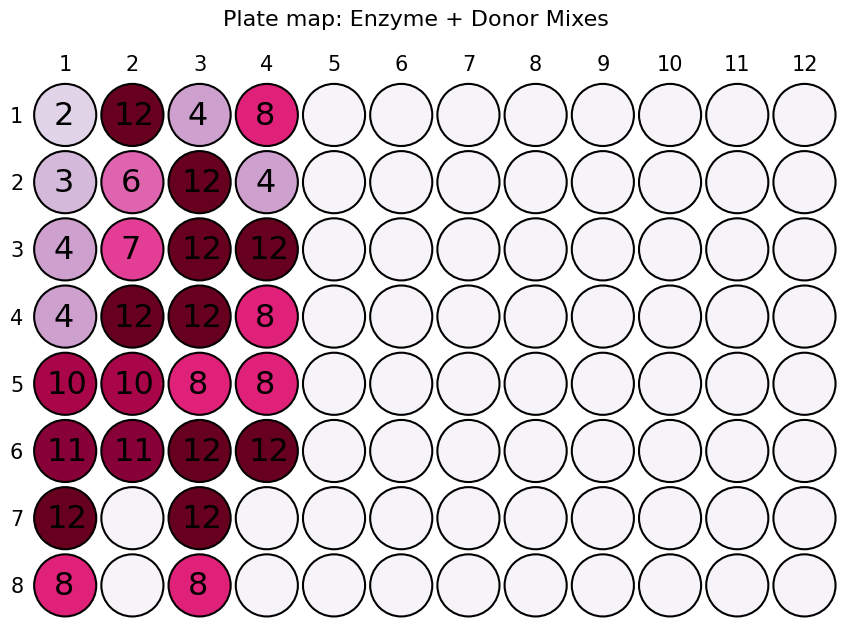

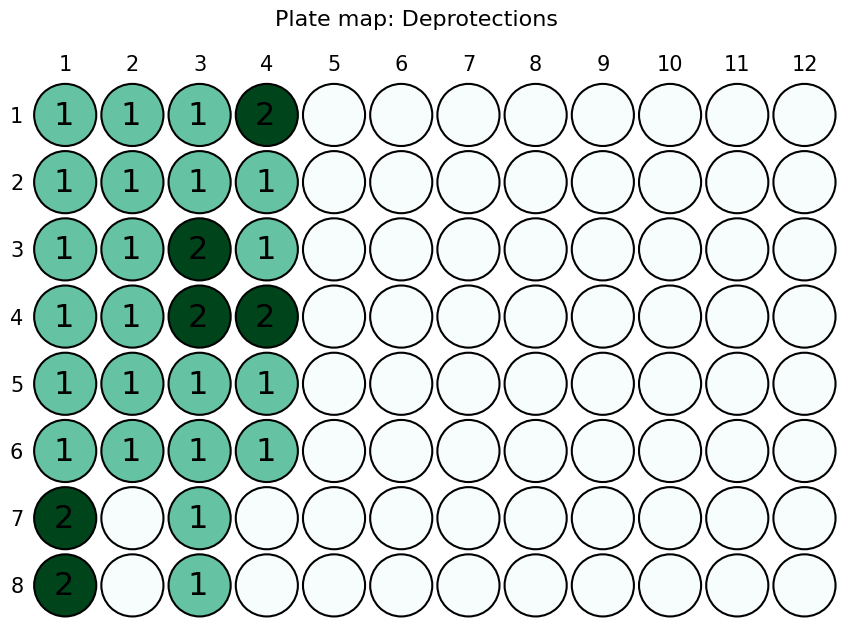

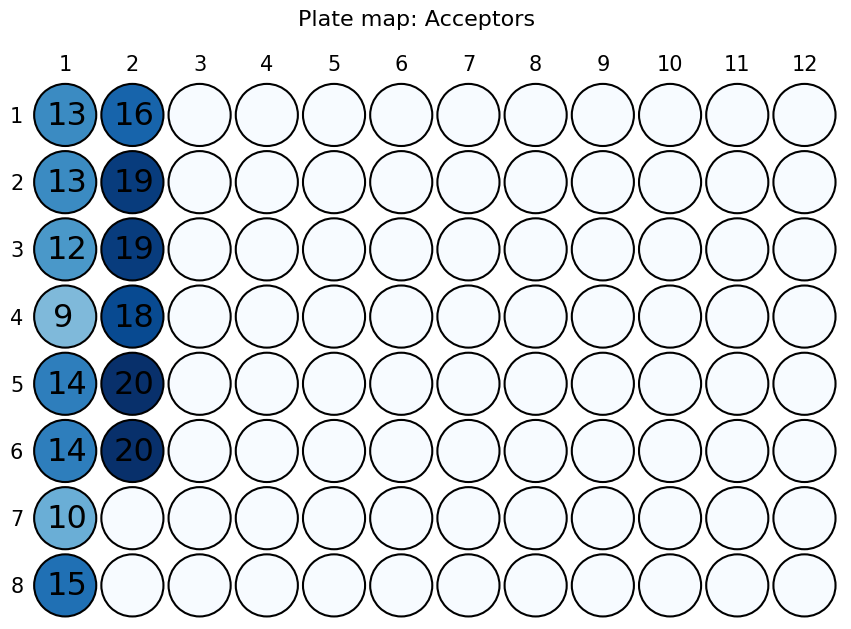

In [ ]:
# Create plate maps for acceptors and deprotections

# create a list of the encoded values
test_indexed_values_tetramers = [423, 427, 363, 31, 443, 447, 95, 143, 191, 315, 319, 279, 335, 339]

output_dict = inner_create_plate_dfs(data_dict, test_indexed_values_tetramers, multimer_size)

enzymes_donors_96 = output_dict['enzymes_donors_96']
deprots_96 = output_dict['deprots_96']
acceptors_96 = output_dict['dimer_acceptors_96']

plot_96wells(cdata=enzymes_donors_96, figure=1, figure_name='Plate map: Enzyme + Donor Mixes', colorbar_type='PuRd')
plot_96wells(cdata=deprots_96, figure=2, figure_name='Plate map: Deprotections', colorbar_type='BuGn')
plot_96wells(cdata=acceptors_96, figure=3, figure_name='Plate map: Acceptors', colorbar_type='Blues')
